In [1]:
"""
Takes soundfont and provides preprocess note gains and post-process velocity curves
"""
import os

global soundfont 
global soundfont_path
global gains_path
global coefficients_path
global outputs_path


soundfont = "Shigeru_Kawai" #Enter Soundfont name for set-up here


soundfont_path = os.path.join("SOURCES/SOUNDFONTS/", soundfont + ".sf2") #Ensure Soundfont is in /SOURCES/SOUNDFONTS/[insert Soundfont name].sf2
gains_path = os.path.join("SOURCES/SF_GAINS/", f"{soundfont}_gains.txt")
coefficients_path = os.path.join("SOURCES/SF_COEFFICIENTS/", f"{soundfont}_coefficients.txt")
outputs_path = f"1_SETUP_OUT/{soundfont}/"
os.makedirs(outputs_path, exist_ok=True)

In [2]:
import os
import numpy as np
import audioread
import librosa
from mido import MidiFile, MidiTrack, MetaMessage, Message
import subprocess
import matplotlib.pyplot as plt

def generate_midi_for_gain(soundfont):
    """
    Generates a MIDI file (and renders a WAV file using fluidsynth) containing all the MIDI notes with max velocity for a given soundfont.
    
    Parameters:
      soundfont (str): Soundfont filename (including extension) for fluidsynth.
    
    Returns:
      tuple: (str, str) where the first element is the filename of the generated WAV file,
             and the second element is the base filename (without extension).
    """
    
    # Hardcoded timing values (ticks)
    note_duration = 480  # on duration: 1 beats
    gap_duration = 3360   # off duration: 7 beats

    # Define filenames.
    original_midi = os.path.join(outputs_path, soundfont + ".mid")
    original_audio = os.path.join(outputs_path, soundfont + ".wav")
    
    # Create a new MIDI file and add two tracks.
    mid = MidiFile(ticks_per_beat=480)
    piano_track = MidiTrack()
    pedal_track = MidiTrack()  # Additional messages can be added if needed.
    mid.tracks.append(piano_track)
    mid.tracks.append(pedal_track)
    
    # Set a tempo (500000 microseconds per beat corresponds to 120 BPM).
    piano_track.append(MetaMessage('set_tempo', tempo=500000, time=0))
    
    # Generate an ordered list of MIDI note numbers (from 21 to 108).
    notes = list(range(21, 109))
    
    # For each note, add the note-on and note-off events with the specified timings.
    for note_number in notes:
        piano_track.append(Message('note_on', note=note_number, velocity=127, time=gap_duration))
        piano_track.append(Message('note_off', note=note_number, velocity=0, time=note_duration))
    
    # Save the MIDI file.
    mid.save(original_midi)
    print(f"MIDI file '{original_midi}' generated successfully!")

    # Render the MIDI to a WAV file using fluidsynth.
    cmd = ["fluidsynth", "-ni", soundfont_path, original_midi, "-F", original_audio, "-r", "44100"]
    try:
        subprocess.run(cmd, check=True)
        print(f"WAV file '{original_audio}' generated successfully!")
    except subprocess.CalledProcessError as e:
        print("Error generating WAV file:", e)
    
    return original_audio, original_midi

In [3]:
import os
import numpy as np
import audioread
import librosa
from mido import MidiFile, MidiTrack, MetaMessage, Message
import subprocess
import matplotlib.pyplot as plt
def load_audio(path, sr=22050, mono=True, offset=0.0, duration=None,
               dtype=np.float32, res_type='kaiser_best', 
               backends=[audioread.ffdec.FFmpegAudioFile]):
    """Load audio. Copied from librosa.core.load() except that the ffmpeg backend is 
    always used in this function."""
    
    y = []
    with audioread.audio_open(os.path.realpath(path), backends=backends) as input_file:
        sr_native = input_file.samplerate
        n_channels = input_file.channels

        s_start = int(np.round(sr_native * offset)) * n_channels

        if duration is None:
            s_end = np.inf
        else:
            s_end = s_start + (int(np.round(sr_native * duration)) * n_channels)

        n = 0

        for frame in input_file:
            # Convert the frame to float values.
            frame = librosa.util.buf_to_float(frame, dtype=dtype)
            n_prev = n
            n += len(frame)

            if n < s_start:
                # Offset is after the current frame: skip it.
                continue

            if s_end < n_prev:
                # We've passed the desired end: stop reading.
                break

            if s_end < n:
                # The end is in this frame: crop it.
                frame = frame[:s_end - n_prev]

            if n_prev <= s_start <= n:
                # The beginning is in this frame: adjust the frame start.
                frame = frame[(s_start - n_prev):]

            # Append the processed frame.
            y.append(frame)
    
    if y:
        y = np.concatenate(y)
        if n_channels > 1:
            y = y.reshape((-1, n_channels)).T
            if mono:
                y = librosa.to_mono(y)
        if sr is not None:
            # Use keyword arguments for original and target sample rates.
            y = librosa.resample(y, orig_sr=sr_native, target_sr=sr, res_type=res_type)
        else:
            sr = sr_native
    else:
        # No audio was loaded; create an empty array.
        y = np.array([], dtype=dtype)

    # Ensure the output array is contiguous and of the desired dtype.
    y = np.ascontiguousarray(y, dtype=dtype)

    return (y, sr)


Processing sound font: Shigeru_Kawai
MIDI file '1_SETUP_OUT/Shigeru_Kawai/Shigeru_Kawai.mid' generated successfully!
WAV file '1_SETUP_OUT/Shigeru_Kawai/Shigeru_Kawai.wav' generated successfully!
Sample rate for Shigeru_Kawai: 22050
Audio data shape for Shigeru_Kawai: (7830784,)
Note constants saved to: SOURCES/SF_GAINS/Shigeru_Kawai_gains.txt


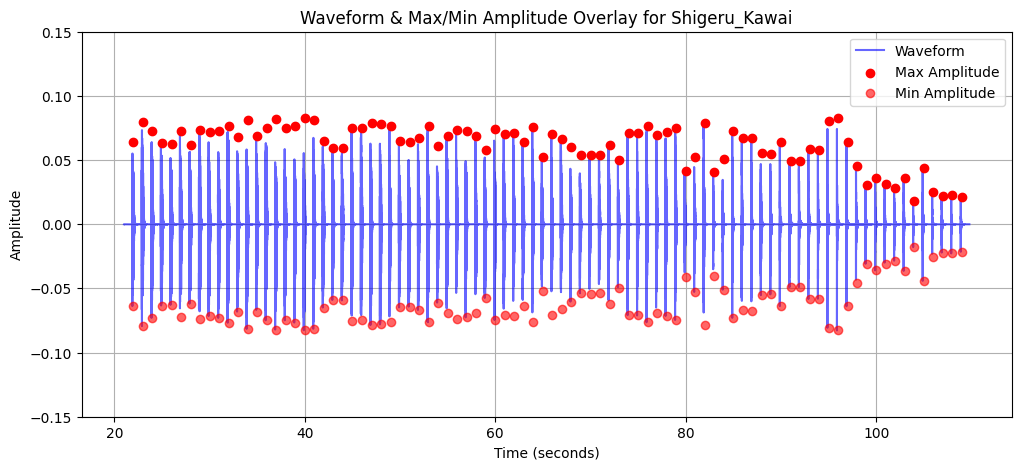

plot saved to 1_SETUP_OUT/Shigeru_Kawai/waveform_with_max_amplitudes.png


In [4]:
#Gains loop    
if __name__ == "__main__":

    # Process each sound font.
    # Assume the sound font file has a .sf2 extension.
    print(f"\nProcessing sound font: {soundfont}")
        
    # Generate MIDI and WAV files.
    original_audio, original_midi = generate_midi_for_gain(soundfont)
        
    # Load the generated audio file.
    audio_data, sample_rate = load_audio(original_audio)
    print(f"Sample rate for {soundfont}: {sample_rate}")
    print(f"Audio data shape for {soundfont}: {audio_data.shape}")
        

    total_note_duration = 4

    # MIDI note range
    notes = list(range(21, 109))

    # Compute max amplitude for each note
    max_amplitudes = []
    max_val = round(max(abs(audio_data)),2)
    gains_data = {} # Create a dictionary to store note and constant

    for i, note in enumerate(notes):
        start_time = i * total_note_duration  # Start time of the note
        end_time = start_time + total_note_duration    # Only consider the ON duration

        start_sample = int((start_time + 0.5*total_note_duration) * sample_rate)
        end_sample = int((end_time + 0.5*total_note_duration) * sample_rate)

        if end_sample > len(audio_data):
            break  # Avoid index error in case of truncation

        # Extract frames and find max amplitude
        current_frame = audio_data[start_sample:end_sample]
        current_max_amplitude = max(abs(current_frame))
        if current_max_amplitude > 0: # Avoid division by zero
            current_gain = max_val / current_max_amplitude
        else:
            current_gain = 0.0 # Or some other default for silent notes

        max_amplitudes.append(current_max_amplitude)
        gains_data[note-21] = current_gain # Store note and constant

    # Write all note constants to the text file after the loop
    with open(gains_path, 'w') as f:
        f.write("Note\tGain\n") # Write a header (optional)
        for note, gain in gains_data.items():
            f.write(f"{note+21}\t{gain}\n")

    print(f"Note constants saved to: {gains_path}")

    import matplotlib.pyplot as plt
    import numpy as np

    # Generate time axis for waveform
    time_axis = np.linspace(21, 21 + (len(audio_data) / (total_note_duration*sample_rate)), num=len(audio_data))

    # Compute note start times (each note is triggered every 1.0 sec)
    note_start_times = np.array([i+22 for i in range(len(notes))])

    # Create the figure
    plt.figure(figsize=(12, 5))

    # Plot the full waveform
    plt.plot(time_axis, audio_data, label="Waveform", alpha=0.6, color='blue')

    # Overlay max amplitude per note as red dots
    plt.scatter(note_start_times, max_amplitudes, color='red', marker='o', label="Max Amplitude", zorder=3)
    # Overlay negative max amplitude as red dots
    plt.scatter(note_start_times, -np.array(max_amplitudes), color='red', marker='o', label="Min Amplitude", zorder=3, alpha=0.6)

    # Labels and Title
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title("Waveform & Max/Min Amplitude Overlay for " + soundfont)
    plt.legend()
    plt.ylim(-0.15, 0.15)
    plt.grid(True)

    # Save and show the figure
    plot_filename = os.path.join(outputs_path, "waveform_with_max_amplitudes.png")
    plt.savefig(plot_filename)
    plt.show()  
    print(f"plot saved to {plot_filename}")

    os.remove(original_audio)
    os.remove(original_midi)

In [5]:
import os
import random
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from mido import Message, MidiFile, MidiTrack, MetaMessage
from IPython.display import Audio


# Clear filenames just in case
originalAUDIO = originalMIDI = originalTXT = originalPNG = None
generatedAUDIO = generatedMIDI = generatedTXT = generatedPNG = None
filename = differencePNG = differenceTXT = None

In [6]:
def set_filenames(note_number):
    global originalAUDIO, originalMIDI, originalTXT, originalPNG
    global generatedAUDIO, generatedMIDI, generatedTXT, generatedPNG
    global filename, differencePNG, differenceTXT

    os.makedirs(os.path.join(outputs_path, "REFERENCE_NOTE"), exist_ok=True)
    os.makedirs(os.path.join(outputs_path, "GENERATED_NOTE"), exist_ok=True)
    os.makedirs(os.path.join(outputs_path, "DIFFERENCE"), exist_ok=True)

    originalAUDIO = os.path.join(outputs_path, f"REFERENCE_NOTE/{note_number}.wav")
    originalMIDI = os.path.join(outputs_path, f"REFERENCE_NOTE/{note_number}.mid")
    originalTXT = os.path.join(outputs_path, f"REFERENCE_NOTE/{note_number}.txt")
    originalPNG = os.path.join(outputs_path, f"REFERENCE_NOTE/{note_number}.png")

    generatedAUDIO = os.path.join(outputs_path, f"GENERATED_NOTE/{note_number}.wav")
    generatedMIDI = os.path.join(outputs_path, f"GENERATED_NOTE/{note_number}.mid")
    generatedTXT = os.path.join(outputs_path, f"GENERATED_NOTE/{note_number}.txt")
    generatedPNG = os.path.join(outputs_path, f"GENERATED_NOTE/{note_number}.png")

    differencePNG = os.path.join(outputs_path, f"DIFFERENCE/{note_number}.png")
    differenceTXT = os.path.join(outputs_path, f"DIFFERENCE/{note_number}.txt")

In [7]:
def load_gains(file_path):
    gains = {}
    try:
        with open(file_path, 'r') as f:
            # Skip the header line if it exists
            next(f)
            for line in f:
                line = line.strip()
                if line:  # Ensure the line is not empty
                    try:
                        note_str, gain_str = line.split('\t')
                        note = int(note_str)
                        gain = float(gain_str)
                        gains[note-21] = gain
                    except ValueError:
                        print(f"Warning: Skipping malformed line in '{file_path}': {line}")
    except FileNotFoundError:
        print(f"Error: File not found at '{file_path}'")
    except Exception as e:
        print(f"An error occurred while reading '{file_path}': {e}")
    return gains

def generate_midi_for_velocity(note_number, random_flag=0):
    """Generates a MIDI file (and renders to WAV) for a given MIDI note number."""
    note_duration = 288  # ~300ms
    gap_duration = 192   # ~200ms

    mid = MidiFile(ticks_per_beat=480)
    piano_track = MidiTrack()
    pedal_track = MidiTrack()
    mid.tracks.extend([piano_track, pedal_track])

    piano_track.append(MetaMessage('set_tempo', tempo=500000, time=0))

    velocities = list(range(128))
    if random_flag:
        random.shuffle(velocities)

    # Insert initial note
    piano_track.append(Message('note_on', note=note_number, velocity=127, time=0))
    piano_track.append(Message('note_off', note=note_number, velocity=0, time=note_duration))

    for i, velocity in enumerate(velocities):
        piano_track.append(Message('note_on', note=note_number, velocity=velocity, time=gap_duration))
        piano_track.append(Message('note_off', note=note_number, velocity=0, time=note_duration))
        if i < len(velocities) - 1:
            piano_track.append(Message('note_on', note=note_number, velocity=127, time=gap_duration))
            piano_track.append(Message('note_off', note=note_number, velocity=0, time=note_duration))

    mid.save(originalMIDI)
    print(f"MIDI saved: {originalMIDI}")
    gain = gains[note_number - 21]
    fluidsynth_cmd = f"fluidsynth -ni {soundfont_path} {originalMIDI} -F {originalAUDIO} -r 44100 -g {gain}"
    subprocess.run(fluidsynth_cmd, shell=True)
    print(f"Audio rendered: {originalAUDIO}")

In [ ]:
def midi_to_text_and_plot(midi_path, text_path, plot_path, title_text):
    """Converts MIDI to text and generates plots."""
    import mido

    midi_file = mido.MidiFile(midi_path)
    ticks_per_beat = midi_file.ticks_per_beat
    tempo = 500000

    velocity_values, velocity_times, note_numbers, note_times = [], [], [], []

    with open(text_path, 'w') as text_file:
        text_file.write(f"MIDI File: {midi_path}\nTicks per Beat: {ticks_per_beat}\n\n")
        absolute_ticks = 0

        for i, track in enumerate(midi_file.tracks):
            text_file.write(f"Track {i}: {track.name}\n{'-'*40}\n")
            for msg in track:
                absolute_ticks += msg.time
                seconds = mido.tick2second(absolute_ticks, ticks_per_beat, tempo)

                if msg.type == 'set_tempo':
                    tempo = msg.tempo

                if msg.type == 'note_on' and msg.velocity > 0:
                    velocity_values.append(msg.velocity)
                    velocity_times.append(seconds)
                    note_numbers.append(msg.note)
                    note_times.append(seconds)
                    text_file.write(f"Time {seconds:.3f} sec | NOTE_ON  | Note: {msg.note:3d} | Velocity: {msg.velocity:3d}\n")
                elif msg.type in ('note_off', 'note_on') and msg.velocity == 0:
                    text_file.write(f"Time {seconds:.3f} sec | NOTE_OFF | Note: {msg.note:3d} | Velocity: 0\n")

    if not velocity_values:
        return

    mapped_notes = [n for n in note_numbers]
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    axes[0, 0].scatter(velocity_times, velocity_values, color='b', alpha=0.7)
    axes[0, 0].set(title="Velocity vs. Time", xlabel="Time (s)", ylabel="Velocity (0–127)")
    axes[0, 0].grid()

    axes[1, 0].scatter(note_times, mapped_notes, color='purple', alpha=0.7)
    axes[1, 0].set(title="MIDI Note Numbers vs. Time", xlabel="Time (s)", ylabel="Piano Key (1–88)")
    axes[1, 0].grid()

    axes[0, 1].hist(velocity_values, bins=128, range=(0, 127), color='green', edgecolor='black')
    axes[0, 1].set(title="Velocity Histogram", xlabel="Velocity", ylabel="Count")

    axes[1, 1].hist(mapped_notes, bins=88, range=(1, 88), color='orange', edgecolor='black')
    axes[1, 1].set(title="Note Number Histogram", xlabel="Piano Key (1–88)", ylabel="Count")

    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()
    print(f"Saved plots to {plot_path}")
    print(f"Saved text to {text_path}")

import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def logistic_curve(x, L, k, x0, b):
    """Defines the logistic curve function."""
    return L / (1 + np.exp(-k * (x - x0))) + b

def save_coefficients_logistic(note_number, params, filename):
    """Saves logistic curve coefficients."""
    formatted = [f"{p:.12g}" for p in params]
    line = f"{note_number}\t" + "\t".join(formatted) + "\n"
    with open(filename, "a") as file:
        file.write(line)

def plot_velocity_mapping(filename):
    """
    Loads data, fits a logistic curve, saves coefficients, and generates plots.
    """
    # Load the data
    data = np.loadtxt(filename)
    if not os.path.exists(filename) or os.stat(filename).st_size == 0:
        print(f"Warning: '{filename}' is missing or empty. Skipping plot generation.")
        return

    # Extract columns
    original_vals = data[:, 0]
    inferred_vals = data[:, 2]
    inferred_midi = data[:, 3]

    # Fit logistic curve
    try:
        popt, pcov = curve_fit(logistic_curve, inferred_vals, original_vals, p0=[np.max(original_vals), 1, np.median(inferred_vals), np.min(original_vals)], maxfev=5000)
        L_opt, k_opt, x0_opt, b_opt = popt
        fitted_originals = logistic_curve(inferred_vals, L_opt, k_opt, x0_opt, b_opt)
        save_coefficients_logistic(note_number, popt, coefficients_path)

        # Calculate R^2 for the logistic fit
        residuals = original_vals - fitted_originals
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((original_vals - np.mean(original_vals))**2)
        r2_score_logistic = 1 - (ss_res / ss_tot)
    except RuntimeError:
        print(f"Error: Optimal parameters not found for logistic fit for note {note_number}.")
        return

    # Sort data
    sort_idx = np.argsort(inferred_vals)
    sorted_inferred = inferred_vals[sort_idx]
    sorted_original = original_vals[sort_idx]
    sorted_fitted_logistic = logistic_curve(sorted_inferred, L_opt, k_opt, x0_opt, b_opt)

    sort_idx2 = np.argsort(original_vals)
    sorted_original2 = original_vals[sort_idx2]
    sorted_fitted_logistic2 = logistic_curve(inferred_vals[sort_idx2], L_opt, k_opt, x0_opt, b_opt)
    sorted_inferred_midi = inferred_midi[sort_idx2]

    fit_error_logistic = sorted_fitted_logistic2 - sorted_original2
    inferred_error = sorted_inferred_midi - sorted_original2

    # Plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    ax1.scatter(sorted_original, sorted_inferred, color='blue', alpha=0.7, label='Original vs Inferred')
    ax1.plot(sorted_fitted_logistic, sorted_inferred, color='red', linewidth=2, label=f'Logistic Fit (R²={r2_score_logistic:.3f})')
    ax1.set_ylabel("inferred Velocity (0:1)")
    ax1.set_xlabel("original MIDI Velocity")
    ax1.set_title(f"Logistic Fit: Original → Inferred\n(Note: {note_number})")
    ax1.text(20.0, 0.97, "Note: " + str(note_number), fontsize=12, verticalalignment='top')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(sorted_original2, sorted_fitted_logistic2, marker='o', linestyle='-', color='green', label='Logistic Fit MIDI Values')
    ax2.plot(sorted_original2, sorted_inferred_midi, marker='s', linestyle='-', color='orange', label='Inferred MIDI Values')
    min_val, max_val = np.min(original_vals), np.max(original_vals)
    ax2.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='y = x')
    ax2.set_xlabel("original MIDI Velocity")
    ax2.set_ylabel("infered MIDI Velocity (0:127)")
    ax2.set_title("Logistic Fit & Inferred MIDI Velocity vs. Original MIDI Velocity")
    ax2.grid(True)
    ax2.legend()

    ax3.plot(sorted_original2, fit_error_logistic, marker='o', linestyle='-', color='green', label='Logistic Fit Error')
    ax3.plot(sorted_original2, inferred_error, marker='o', linestyle='-', color='orange', label='Inferred Velocity Error')
    ax3.axhline(0, color='black', linestyle='--', label='Zero Error')
    ax3.set_xlabel("original MIDI Velocity")
    ax3.set_ylabel("Error")
    ax3.set_title("Logistic Fit & Inferred MIDI Velocity Error vs. Original MIDI Velocity")
    ax3.grid(True)
    ax3.set_ylim(-40, 40)
    ax3.legend()

    plt.savefig(differencePNG)
    plt.tight_layout()
    plt.show()
    print(f"PLOTS saved to: {differencePNG}")

#Coefficients Loop
gains = load_gains(gains_path)
#Remove existing coefficients txt file if it exists
if os.path.exists(coefficients_path):
    os.remove(coefficients_path) 

for note_number in range(21, 109):
    set_filenames(note_number)
    generate_midi_for_velocity(note_number)
    midi_to_text_and_plot(originalMIDI, originalTXT, originalPNG, f"Reference Note {note_number}")

    subprocess.run(f"python example.py --audio_path={originalAUDIO} --output_midi_path={generatedMIDI}", shell=True)

    try:
        with open("output.txt", "r") as infile:
            lines = infile.readlines()
    except FileNotFoundError:
        print("output.txt not found.")
        continue

    filtered = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 2 and parts[1].isdigit() and int(parts[1]) == note_number:
            filtered.append(line.strip())

    with open(generatedTXT, "w") as outfile:
        outfile.write("\n".join(filtered))

    print(f"{len(filtered)} lines written to {generatedTXT}")
    plot_velocity_mapping(generatedTXT)